source:<br>
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Preliminaries

## Libraries

In [2]:
from pandas import read_csv, DataFrame, Series, concat
from datetime import datetime
from os.path import expanduser
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc

# Keras + Tensorflow 1.X
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM, GRU
#from keras.optimizers import adam

# Tensorflow 2.X
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam

# LightGBM
import lightgbm as lgbm

# CatBoost
from catboost import CatBoostRegressor

## Settings

In [3]:
%matplotlib inline

In [4]:
# Ggplot Style
plt.style.use('ggplot')

In [5]:
# Set Plot Dimensions (overall)
plt.rcParams['figure.figsize'] = (10, 9/16*10)
plt.rcParams['font.size'] = 10

## Workdir

In [6]:
_homedir = expanduser("~")
_datadir = _homedir+"/Data/Pollution/"

## Dataset Preparation

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain.

In [6]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

filename = 'raw_pollution.csv'

dataset = read_csv(_datadir+filename,  
                   parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv(_datadir+'pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


# Dataset

In [7]:
# load dataset
dataset = read_csv(_datadir+'pollution.csv', header=0, index_col=0)

In [8]:
dataset.head(n=10)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [11]:
print("# of records --> {:,}".format(dataset.shape[0]))
print("They correspond to {:.0f} years of data".format(dataset.shape[0]/(365*24)))

# of records --> 43,800
They correspond to 5 years of data


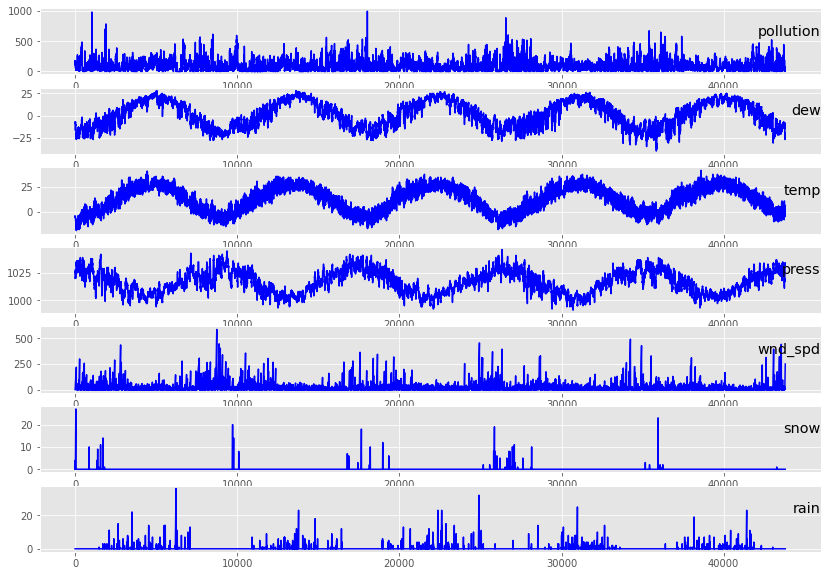

In [12]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
plt.figure(figsize=(14, 10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dataset.values[:, group], c='b')
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## Statistical Analysis

Let's see the temperature autocorrelation

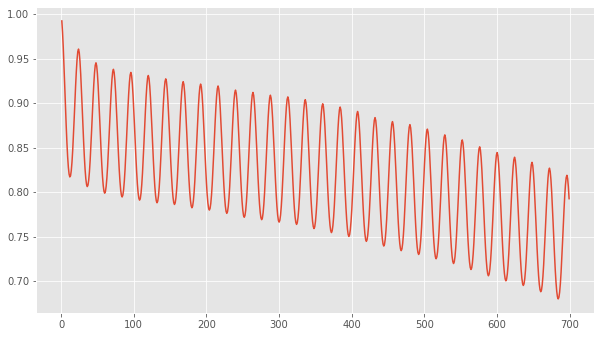

In [13]:
temp_autocorr = [dataset["temp"].autocorr(lag=l) for l in range(1,4*7*25)]

plt.plot(range(1,len(temp_autocorr)+1),temp_autocorr);

Pollution autocorrelation

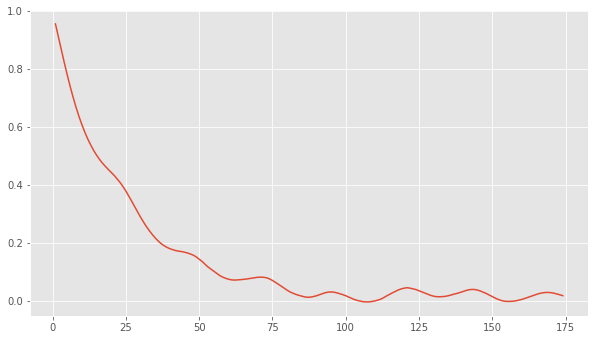

In [14]:
pollution_autocorr = [dataset["pollution"].autocorr(lag=l) for l in range(1,7*25)]

plt.plot(range(1,len(pollution_autocorr)+1),pollution_autocorr);

In [15]:
dates_index = dataset.index
dates = pd.to_datetime(dates_index)

dataset['day'] = dates.date

In [16]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,day
date,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02


In [17]:
avg_daily_temp = dataset[['temp','day']].groupby('day').apply(np.mean)

avg_daily_temp.describe()

,temp
count,1825.000000
mean,12.459041
std,11.552997
min,-14.458333
25%,1.541667
50%,13.916667
75%,23.166667
max,32.875000


In [18]:
dataset.snow.describe()

count    43800.000000
mean         0.052763
std          0.760582
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         27.000000
Name: snow, dtype: float64

## Data Preparation 

We can transform the (multivariate) time series dataset into a suitable supervised learning dataset using the <b>series_to_supervised()</b> function

In [19]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [20]:
values = dataset.values

print("# records --> {:}\n# features --> {}".format(values.shape[0],values.shape[1]))

# records --> 43800
# features --> 9


In [21]:
values[0]

array([129.0, -16, -4.0, 1020.0, 'SE', 1.79, 0, 0,
       datetime.date(2010, 1, 2)], dtype=object)

In [22]:
series_to_supervised(values[:,[0,1]],n_in=3,n_out=3).head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t),var1(t+1),var2(t+1),var1(t+2),var2(t+2)
3,129.0,-16,148.0,-15,159.0,-11,181.0,-7,138.0,-7,109.0,-7
4,148.0,-15,159.0,-11,181.0,-7,138.0,-7,109.0,-7,105.0,-7
5,159.0,-11,181.0,-7,138.0,-7,109.0,-7,105.0,-7,124.0,-7
6,181.0,-7,138.0,-7,109.0,-7,105.0,-7,124.0,-7,120.0,-8
7,138.0,-7,109.0,-7,105.0,-7,124.0,-7,120.0,-8,132.0,-7


In [23]:
DataFrame({'feature':dataset.columns, 'var':['var'+str(idx) for idx in range(1,len(dataset.columns)+1)]}) 

,feature,var
0,pollution,var1
1,dew,var2
2,temp,var3
3,press,var4
4,wnd_dir,var5
5,wnd_spd,var6
6,snow,var7
7,rain,var8
8,day,var9


Let's see some example.

Suppose we want to predict the pollution value at time <b>t+1</b> given the values of:
- <b>pollution</b> 
- <b>dew</b>
- <b>temperature</b> 

at <b>t-2</b> and <b>t-1</b>.

The problem can be cast in a supervised lerning setting.

In [83]:
series_to_supervised(values[:,[0,1,2]],n_in=2,n_out=2).head()

,var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t),var1(t+1),var2(t+1),var3(t+1)
2,129,-16,-4,148,-15,-4,159,-11,-5,181,-7,-5
3,148,-15,-4,159,-11,-5,181,-7,-5,138,-7,-5
4,159,-11,-5,181,-7,-5,138,-7,-5,109,-7,-6
5,181,-7,-5,138,-7,-5,109,-7,-6,105,-7,-6
6,138,-7,-5,109,-7,-6,105,-7,-6,124,-7,-5


In [106]:
ml_dataset = series_to_supervised(values[:,[0,1,2]],n_in=2,n_out=2).iloc[:,[0,1,2,3,4,5,9]]

In [107]:
ml_dataset.head()

,var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t+1)
2,129,-16,-4,148,-15,-4,181
3,148,-15,-4,159,-11,-5,138
4,159,-11,-5,181,-7,-5,109
5,181,-7,-5,138,-7,-5,105
6,138,-7,-5,109,-7,-6,124


In [108]:
ml_dataset = ml_dataset.astype(float)

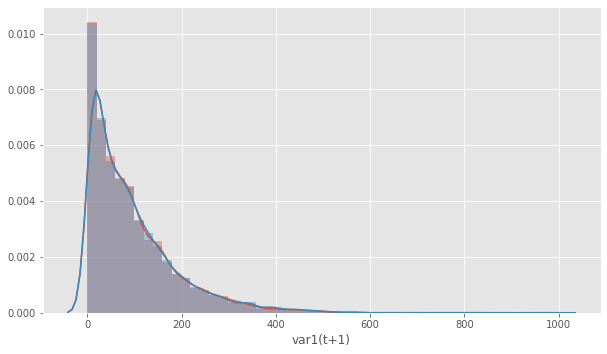

In [109]:
# Pollution Distributions

sns.distplot(ml_dataset['var1(t-2)'].sample(10000));
sns.distplot(ml_dataset['var1(t+1)'].sample(10000));

In [110]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 2
n_hours_prediction = 3 # 2-hours prediction
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_hours_prediction)

# drop columns we don't want to predict
reframed.drop(reframed.columns[list(range(24,32))+list(range(33,40))], axis=1, inplace=True)
n_hours_predictor = 3 # change accordingly to previous line, e.g. t-2, t-1, t
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),...,var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var1(t+2)
2,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.138833
3,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.109658
4,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.105634
5,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.124748
6,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0,0.120724


In [112]:
# split into train and test sets
values_reframed = reframed.values
n_train_hours = 3 * 365 * 24
train = values_reframed[:n_train_hours, :]
test = values_reframed[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 24) (26280,) (17516, 1, 24) (17516,)


## Data Preparation for Recurrent Neural Network

Starting dataset: <b>scaled</b>


COMPLETE WITH A DESCRIPTION OF THE APPROACH...

In [119]:
# target normalization
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(values[:,0].reshape(-1, 1))

In [120]:
DataFrame({'feature':dataset.columns, 'var':['var'+str(idx) for idx in range(1,len(dataset.columns)+1)]}) 

,feature,var
0,pollution,var1
1,dew,var2
2,temp,var3
3,press,var4
4,wnd_dir,var5
5,wnd_spd,var6
6,snow,var7
7,rain,var8


In our case the target is the first variable.

The function assumes as predictors $x_0(t-nsteps),\,x_0(t-nsteps+1),\ldots\,x_0(t)$ in order to forecast $x_0(t+pred steps)$, 

In [121]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, pred_steps=1):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if (end_ix + n_steps > len(sequences)) or (end_ix+(pred_steps) > len(sequences)):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix,:], sequences[end_ix+(pred_steps - 1),0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [149]:
lags = 3
pred_lags = 2

X, y = split_sequences(scaled,lags,pred_lags)

In [150]:
print(X.shape, y.shape)

(43795, 3, 8) (43795,)


In [151]:
# Define train-test
train_steps = 20000

X_train, X_test = X[:train_steps], X[train_steps:]
y_train, y_test = y[:train_steps], y[train_steps:]

# Model Building

## Recurrent Neural Networks

### LSTM

Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with train_X.shape[2] features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

In [91]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
#model.compile(loss='mae', optimizer='RMSprop')
#adam_opt_custom = adam(lr=0.01)
#model.compile(loss='mse', optimizer=adam_opt_custom)

# fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 17516 samples
Epoch 1/40
26280/26280 - 3s - loss: 0.0326 - val_loss: 0.0280
Epoch 2/40
26280/26280 - 3s - loss: 0.0246 - val_loss: 0.0263
Epoch 3/40
26280/26280 - 2s - loss: 0.0237 - val_loss: 0.0253
Epoch 4/40
26280/26280 - 2s - loss: 0.0230 - val_loss: 0.0253
Epoch 5/40
26280/26280 - 2s - loss: 0.0225 - val_loss: 0.0254
Epoch 6/40
26280/26280 - 2s - loss: 0.0223 - val_loss: 0.0253
Epoch 7/40
26280/26280 - 3s - loss: 0.0221 - val_loss: 0.0248
Epoch 8/40
26280/26280 - 4s - loss: 0.0219 - val_loss: 0.0247
Epoch 9/40
26280/26280 - 3s - loss: 0.0218 - val_loss: 0.0244
Epoch 10/40
26280/26280 - 2s - loss: 0.0216 - val_loss: 0.0242
Epoch 11/40
26280/26280 - 4s - loss: 0.0215 - val_loss: 0.0240
Epoch 12/40
26280/26280 - 2s - loss: 0.0214 - val_loss: 0.0243
Epoch 13/40
26280/26280 - 2s - loss: 0.0215 - val_loss: 0.0242
Epoch 14/40
26280/26280 - 3s - loss: 0.0215 - val_loss: 0.0241
Epoch 15/40
26280/26280 - 3s - loss: 0.0214 - val_loss: 0.0240
Epoch 16/40
26

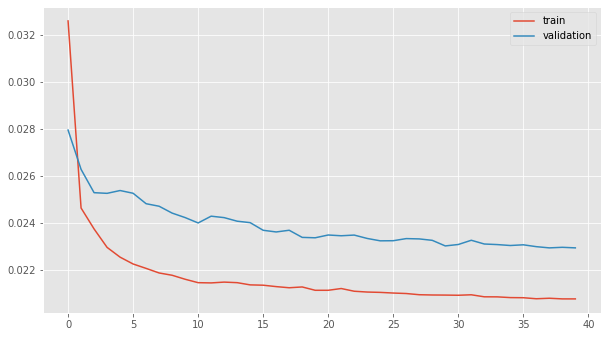

In [92]:
# plot history
plt.plot(history.history['loss'], label='train');
plt.plot(history.history['val_loss'], label='validation');
plt.legend();

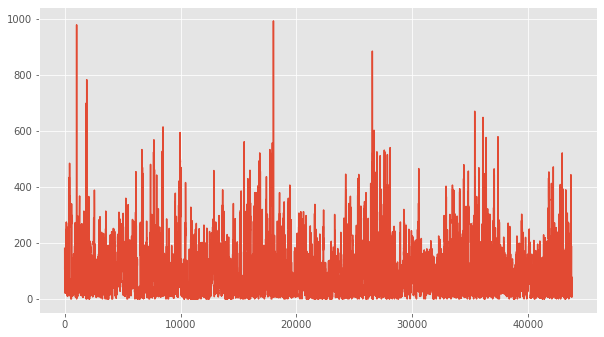

In [74]:
plt.plot(range(1,ml_dataset['var1(t+1)'].shape[0]+1),ml_dataset['var1(t+1)']);

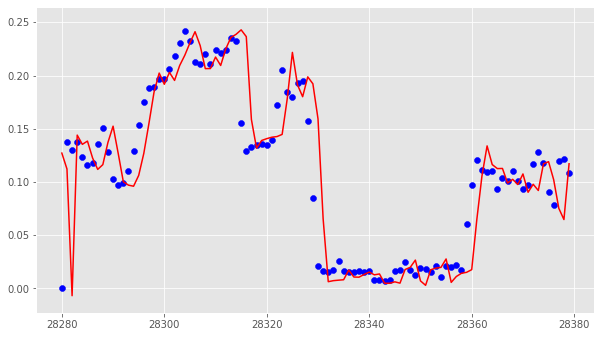

In [93]:
_time_start = 2000
_time_steps = 100
_t_steps = range(n_train_hours+_time_start, n_train_hours+_time_start+_time_steps)

plt.scatter(_t_steps,test_y[_time_start:_time_start+_time_steps],c='b');
plt.plot(_t_steps,model.predict(test_X[_time_start:_time_start+_time_steps]),c='r');

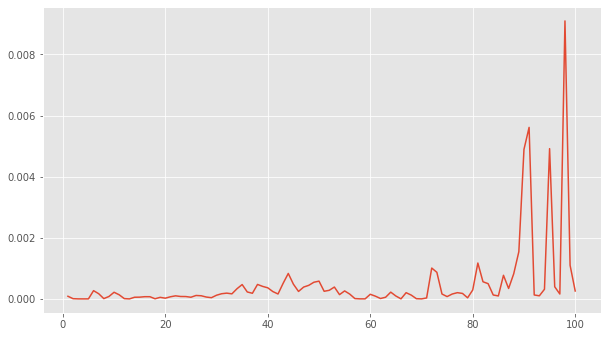

In [94]:
_diff = np.power(model.predict(test_X[0:_time_steps]).flatten()-test_y[0:_time_steps],2)

plt.plot(range(1,len(_diff)+1),_diff);

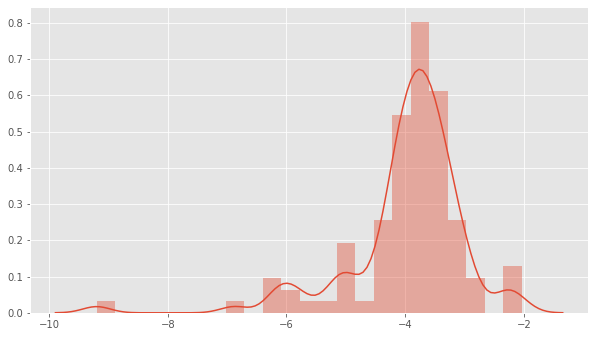

In [95]:
sns.distplot(np.log10(_diff));

In [96]:
Series(_diff).describe()

count    1.000000e+02
mean     4.794449e-04
std      1.242967e-03
min      6.334313e-10
25%      6.737387e-05
50%      1.599401e-04
75%      3.691631e-04
max      9.098211e-03
dtype: float64

In [97]:
# LSTM Predictions inverse rescaling
yhat_lstm = model.predict(test_X)
inv_yhat_lstm = np.concatenate((yhat_lstm,
                                test_X.reshape((test_X.shape[0], n_hours_predictor*n_features))[:, -7:]),
                               axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,0]

# Actual inverse rescaling
inv_y = np.concatenate((test_y.reshape((len(test_y), 1)), 
                        test_X.reshape((test_X.shape[0], n_hours_predictor*n_features))[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# RMSE computation
rmse_lstm = np.sqrt(mean_squared_error(inv_y, inv_yhat_lstm))

# MAE computation
mae_lstm = mean_absolute_error(inv_y, inv_yhat_lstm)

In [98]:
print("RMSE LSTM --> {:5.2f}\nMAE LSTM --> {:5.2f}".format(rmse_lstm,mae_lstm))

RMSE LSTM --> 39.27
MAE LSTM --> 22.80


### LSTM by using timestamp

The key information about the two possible approaches to recurrent layer sequence input is encoded in the following line 

In [128]:
print(X_train.shape)
print(train_X.shape)

(20000, 3, 8)
(26280, 1, 24)


In [142]:
X_train[0]

array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ],
       [0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
        0.00533197, 0.        , 0.        ]], dtype=float32)

In [143]:
train_X[0]

array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        , 0.14889336, 0.36764708,
        0.24590163, 0.5272732 , 0.6666667 , 0.00381099, 0.        ,
        0.        , 0.15995975, 0.4264706 , 0.22950819, 0.545454  ,
        0.6666667 , 0.00533197, 0.        , 0.        ]], dtype=float32)

In [158]:
# design network
model = Sequential()
model.add(LSTM(120, input_shape=(X_train.shape[1],X_train.shape[2])))
#model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
#model.compile(loss='mae', optimizer='RMSprop')
#adam_opt_custom = adam(lr=0.01)
#model.compile(loss='mse', optimizer=adam_opt_custom)

# fit network
history = model.fit(X_train, y_train, epochs=20, batch_size=72, 
                    validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 20000 samples, validate on 23795 samples
Epoch 1/20
20000/20000 - 17s - loss: 0.0366 - val_loss: 0.0303
Epoch 2/20
20000/20000 - 10s - loss: 0.0265 - val_loss: 0.0270
Epoch 3/20
20000/20000 - 12s - loss: 0.0254 - val_loss: 0.0249
Epoch 4/20
20000/20000 - 10s - loss: 0.0244 - val_loss: 0.0239
Epoch 5/20
20000/20000 - 11s - loss: 0.0235 - val_loss: 0.0225
Epoch 6/20
20000/20000 - 10s - loss: 0.0227 - val_loss: 0.0219
Epoch 7/20
20000/20000 - 11s - loss: 0.0221 - val_loss: 0.0215
Epoch 8/20
20000/20000 - 12s - loss: 0.0220 - val_loss: 0.0212
Epoch 9/20
20000/20000 - 11s - loss: 0.0220 - val_loss: 0.0210
Epoch 10/20
20000/20000 - 10s - loss: 0.0218 - val_loss: 0.0209
Epoch 11/20
20000/20000 - 11s - loss: 0.0218 - val_loss: 0.0208
Epoch 12/20
20000/20000 - 10s - loss: 0.0217 - val_loss: 0.0207
Epoch 13/20
20000/20000 - 10s - loss: 0.0216 - val_loss: 0.0208
Epoch 14/20
20000/20000 - 10s - loss: 0.0216 - val_loss: 0.0206
Epoch 15/20
20000/20000 - 10s - loss: 0.0215 - val_loss: 0.0206

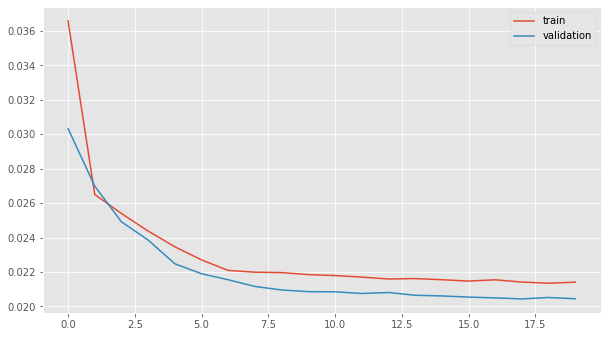

In [159]:
# plot history
plt.plot(history.history['loss'], label='train');
plt.plot(history.history['val_loss'], label='validation');
plt.legend();

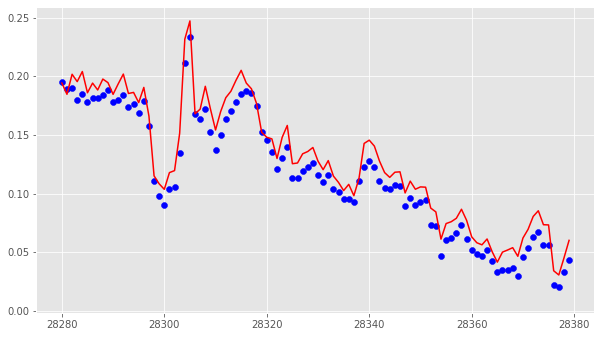

In [160]:
_time_start = 2000
_time_steps = 100
_t_steps = range(n_train_hours+_time_start, n_train_hours+_time_start+_time_steps)

plt.scatter(_t_steps,y_test[_time_start:_time_start+_time_steps],c='b');
plt.plot(_t_steps,model.predict(X_test[_time_start+pred_lags:_time_start+_time_steps+pred_lags]),c='r');

In [161]:
# LSTM Predictions inverse rescaling
yhat_lstm = model.predict(X_test)
inv_yhat_lstm = target_scaler.inverse_transform(yhat_lstm.reshape(-1, 1))

# Actual inverse rescaling
inv_y = target_scaler.inverse_transform(y_test.reshape(-1,1))

# RMSE computation
rmse_lstm = np.sqrt(mean_squared_error(inv_y, inv_yhat_lstm))

# MAE computation
mae_lstm = mean_absolute_error(inv_y, inv_yhat_lstm)

In [162]:
print("RMSE LSTM --> {:5.3f}\nMAE LSTM --> {:5.3f}".format(rmse_lstm,mae_lstm))

RMSE LSTM --> 36.575
MAE LSTM --> 20.320


### GRU

In [233]:
# design network
model_gru = Sequential()
model_gru.add(GRU(100, input_shape=(train_X.shape[1], train_X.shape[2]), 
                  dropout=0.01, 
                  kernel_initializer='glorot_normal', 
                  recurrent_activation='sigmoid',
                  return_sequences=True))
#model.add(GRU(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(GRU(50,dropout=0.01,kernel_initializer='glorot_normal',recurrent_activation='sigmoid'))
model_gru.add(Dense(1))

model_gru.compile(loss='mae', optimizer='adam')
#model.compile(loss='mae', optimizer='RMSprop')
#adam_opt_custom = adam(lr=0.01)
#model.compile(loss='mse', optimizer=adam_opt_custom)

# fit network
history_gru = model_gru.fit(train_X, train_y, epochs=50, batch_size=100,
                            validation_data=(test_X, test_y), 
                            verbose=2, shuffle=False)

Train on 26280 samples, validate on 17516 samples
Epoch 1/50
26280/26280 - 19s - loss: 0.0346 - val_loss: 0.0298
Epoch 2/50
26280/26280 - 9s - loss: 0.0262 - val_loss: 0.0284
Epoch 3/50
26280/26280 - 10s - loss: 0.0250 - val_loss: 0.0258
Epoch 4/50
26280/26280 - 9s - loss: 0.0240 - val_loss: 0.0239
Epoch 5/50
26280/26280 - 9s - loss: 0.0235 - val_loss: 0.0268
Epoch 6/50
26280/26280 - 7s - loss: 0.0237 - val_loss: 0.0236
Epoch 7/50
26280/26280 - 9s - loss: 0.0234 - val_loss: 0.0225
Epoch 8/50
26280/26280 - 11s - loss: 0.0235 - val_loss: 0.0233
Epoch 9/50
26280/26280 - 9s - loss: 0.0232 - val_loss: 0.0240
Epoch 10/50
26280/26280 - 7s - loss: 0.0230 - val_loss: 0.0227
Epoch 11/50
26280/26280 - 9s - loss: 0.0230 - val_loss: 0.0229
Epoch 12/50
26280/26280 - 7s - loss: 0.0227 - val_loss: 0.0233
Epoch 13/50
26280/26280 - 7s - loss: 0.0225 - val_loss: 0.0230
Epoch 14/50
26280/26280 - 7s - loss: 0.0225 - val_loss: 0.0237
Epoch 15/50
26280/26280 - 10s - loss: 0.0226 - val_loss: 0.0239
Epoch 16/5

In [238]:
model_gru.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 1, 100)            37800     
_________________________________________________________________
gru_9 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 60,651
Trainable params: 60,651
Non-trainable params: 0
_________________________________________________________________


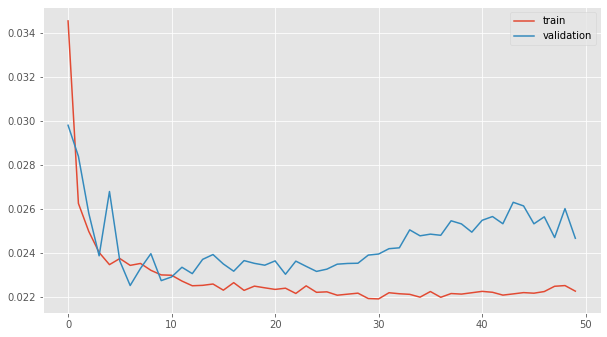

In [234]:
# plot history
plt.plot(history_gru.history['loss'], label='train');
plt.plot(history_gru.history['val_loss'], label='validation');
plt.legend();

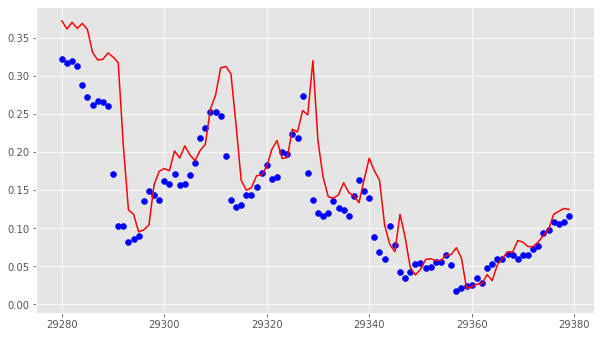

In [235]:
_time_start = 3000
_time_steps = 100
_t_steps = range(n_train_hours+_time_start, n_train_hours+_time_start+_time_steps)

plt.scatter(_t_steps,test_y[_time_start:_time_start+_time_steps],c='b');
plt.plot(_t_steps,model_gru.predict(test_X[_time_start:_time_start+_time_steps]),c='r');

In [236]:
# GRU Predictions inverse rescaling
yhat_gru = model_gru.predict(test_X)
inv_yhat_gru = target_scaler.inverse_transform(yhat_gru.reshape(-1, 1))

# Actual target inverse rescaling
inv_y = target_scaler.inverse_transform(test_y.reshape(-1,1))

# RMSE computation
rmse_gru = np.sqrt(mean_squared_error(inv_y, inv_yhat_gru))

In [237]:
print("RMSE GRU --> {:5.2f}".format(rmse_gru))

RMSE GRU --> 41.75


## Random Forest

In [170]:
train.shape

(26280, 25)

In [171]:
feat_train = train[:,0:24]
target_train = train[:,-1]
feat_test = test[:,0:24]
target_test = test[:,-1]

In [172]:
rf_model = RandomForestRegressor(n_estimators=500, 
                                 criterion='mse',
                                 n_jobs=4)

In [173]:
rf_model.fit(feat_train,target_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=4, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

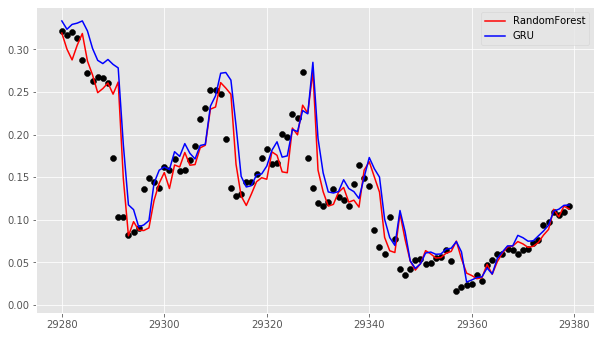

In [186]:
_time_start = 3000
_time_steps = 100
_t_steps = range(n_train_hours+_time_start, n_train_hours+_time_start+_time_steps)

plt.scatter(_t_steps,test_y[_time_start:_time_start+_time_steps],c='black');
plt.plot(_t_steps,rf_model.predict(feat_test[_time_start:_time_start+_time_steps]),c='r',
         label='RandomForest');
plt.plot(_t_steps,model_gru.predict(test_X[_time_start:_time_start+_time_steps]),c='b',
         label='GRU');
plt.legend();

Let's compute the mean squared error:<br>

$ MSE(y,\,\hat{y}) = \frac{1}{n_{{\rm samples}}-1}\sum_{i=0}^{n_{{\rm samples}}-1}\left(y_i -\hat{y}_i\right)^2$

In [189]:
# RF Predictions inverse rescaling
yhat_rf = rf_model.predict(feat_test)
inv_yhat_rf = np.concatenate((yhat_rf.reshape(-1,1),feat_test[:, -7:]),axis=1)
inv_yhat_rf = scaler.inverse_transform(inv_yhat_rf)
inv_yhat_rf = inv_yhat_rf[:,0]

# RMSE computation
rmse_rf = np.sqrt(mean_squared_error(inv_y, inv_yhat_rf))

In [201]:
print("RMSE LSTM --> {:5.3f}\nRMSE GRU --> {:5.3f}\nRMSE RF --> {:5.3f}".format(rmse_lstm,
                                                                                rmse_gru,
                                                                                rmse_rf))

RMSE LSTM --> 36.575
RMSE GRU --> 38.626
RMSE RF --> 38.063


## Feed-Forward Neural Network 

In [202]:
input_dim = feat_train.shape[1]

In [203]:
# design network
model_nn = Sequential()
model_nn.add(Dense(30, input_dim=input_dim, activation='relu'))
#model_nn.add(Dense(50, activation='relu'))
model_nn.add(Dense(1))
model_nn.compile(loss='mae', optimizer='adam')
# fit network
history_nn = model_nn.fit(feat_train, target_train, epochs=30, batch_size=50,
                          validation_data=(feat_test, target_test), verbose=2, shuffle=False)

Train on 26280 samples, validate on 17516 samples
Epoch 1/30
26280/26280 - 6s - loss: 0.0441 - val_loss: 0.0299
Epoch 2/30
26280/26280 - 5s - loss: 0.0276 - val_loss: 0.0274
Epoch 3/30
26280/26280 - 4s - loss: 0.0253 - val_loss: 0.0251
Epoch 4/30
26280/26280 - 4s - loss: 0.0243 - val_loss: 0.0242
Epoch 5/30
26280/26280 - 5s - loss: 0.0234 - val_loss: 0.0271
Epoch 6/30
26280/26280 - 6s - loss: 0.0229 - val_loss: 0.0273
Epoch 7/30
26280/26280 - 5s - loss: 0.0227 - val_loss: 0.0279
Epoch 8/30
26280/26280 - 5s - loss: 0.0223 - val_loss: 0.0285
Epoch 9/30
26280/26280 - 5s - loss: 0.0224 - val_loss: 0.0283
Epoch 10/30
26280/26280 - 5s - loss: 0.0223 - val_loss: 0.0284
Epoch 11/30
26280/26280 - 5s - loss: 0.0221 - val_loss: 0.0265
Epoch 12/30
26280/26280 - 5s - loss: 0.0223 - val_loss: 0.0263
Epoch 13/30
26280/26280 - 4s - loss: 0.0220 - val_loss: 0.0250
Epoch 14/30
26280/26280 - 5s - loss: 0.0221 - val_loss: 0.0241
Epoch 15/30
26280/26280 - 4s - loss: 0.0219 - val_loss: 0.0246
Epoch 16/30
26

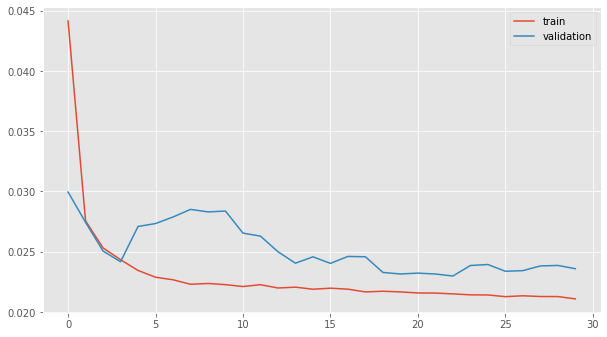

In [204]:
# plot history
plt.plot(history_nn.history['loss'], label='train');
plt.plot(history_nn.history['val_loss'], label='validation');
plt.legend();

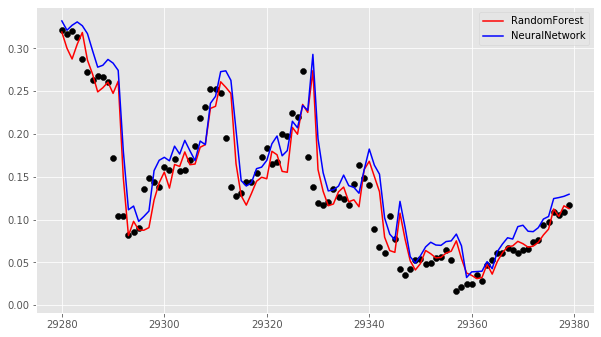

In [205]:
_time_start = 3000
_time_steps = 100

_t_steps = range(n_train_hours+_time_start, n_train_hours+_time_start+_time_steps)

plt.scatter(_t_steps,test_y[_time_start:_time_start+_time_steps],c='black');
plt.plot(_t_steps,rf_model.predict(feat_test[_time_start:_time_start+_time_steps]),c='r',
         label='RandomForest');
plt.plot(_t_steps,model_nn.predict(feat_test[_time_start:_time_start+_time_steps]),c='b',
         label='NeuralNetwork');
plt.legend();

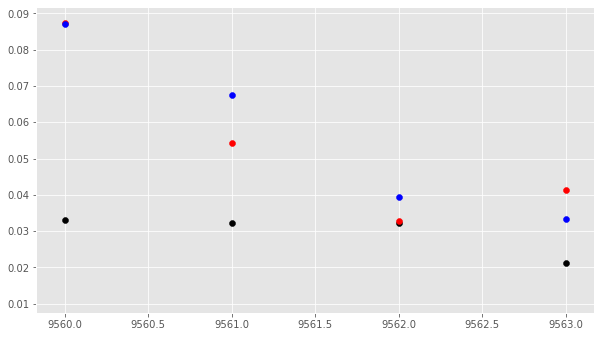

In [203]:
_time_start = 800
_time_steps = 4
_t_steps = range(n_train_hours+_time_start, n_train_hours+_time_start+_time_steps)

plt.scatter(_t_steps,test_y[_time_start:_time_start+_time_steps],c='black');
plt.scatter(_t_steps,rf_model.predict(feat_test[_time_start:_time_start+_time_steps]),c='red');
plt.scatter(_t_steps,model_nn.predict(feat_test[_time_start:_time_start+_time_steps]),c='blue');

In [206]:
# NN Predictions inverse rescaling
yhat_nn = model_nn.predict(feat_test)
inv_yhat_nn = np.concatenate((yhat_nn.reshape(-1,1),feat_test[:, -7:]),axis=1)
inv_yhat_nn = scaler.inverse_transform(inv_yhat_nn)
inv_yhat_nn = inv_yhat_nn[:,0]

# RMSE computation
rmse_nn = np.sqrt(mean_squared_error(inv_y, inv_yhat_nn))

In [207]:
print("RMSE LSTM --> {:5.3f}\nRMSE NN --> {:5.3f}\nRMSE RF --> {:5.3f}".format(rmse_lstm,
                                                                               rmse_nn,
                                                                               rmse_rf))

RMSE LSTM --> 36.575
RMSE NN --> 39.259
RMSE RF --> 38.063


## LightGBM 

The LightGBM Python module can load data from:

- libsvm/tsv/csv/txt format file
- NumPy 2D array(s), pandas DataFrame, H2O DataTable’s Frame, SciPy sparse matrix
- LightGBM binary file

The data is stored in a <b>Dataset</b> object.

In [208]:
train_lgbm = lgbm.Dataset(feat_train, label=target_train)
test_lgbm = lgbm.Dataset(feat_test, label=target_test)

In [209]:
parameters = {
    'application': 'mae',
    'objective': 'regression',
    'metric': 'mae',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.4,
    'bagging_freq': 20,
    'learning_rate': 0.01,
    'verbose': 0
}

lgbm_model = lgbm.train(parameters,
                        train_lgbm,
                        valid_sets=test_lgbm,
                        num_boost_round=5000,
                        early_stopping_rounds=100)

[1]	valid_0's l1: 0.0684383
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 0.0678606
[3]	valid_0's l1: 0.0672886
[4]	valid_0's l1: 0.0667803
[5]	valid_0's l1: 0.0662189
[6]	valid_0's l1: 0.0656646
[7]	valid_0's l1: 0.0651166
[8]	valid_0's l1: 0.0645756
[9]	valid_0's l1: 0.0640388
[10]	valid_0's l1: 0.0635115
[11]	valid_0's l1: 0.0629897
[12]	valid_0's l1: 0.0624722
[13]	valid_0's l1: 0.0619636
[14]	valid_0's l1: 0.0615078
[15]	valid_0's l1: 0.0610069
[16]	valid_0's l1: 0.0605133
[17]	valid_0's l1: 0.0600297
[18]	valid_0's l1: 0.0595431
[19]	valid_0's l1: 0.0590672
[20]	valid_0's l1: 0.0585999
[21]	valid_0's l1: 0.0581348
[22]	valid_0's l1: 0.0576751
[23]	valid_0's l1: 0.0572254
[24]	valid_0's l1: 0.0567758
[25]	valid_0's l1: 0.0563328
[26]	valid_0's l1: 0.0558972
[27]	valid_0's l1: 0.0554634
[28]	valid_0's l1: 0.0550412
[29]	valid_0's l1: 0.0546181
[30]	valid_0's l1: 0.0542045
[31]	valid_0's l1: 0.0537918
[32]	valid_0's l1: 0.053386
[33]	valid_0's l1: 0

[280]	valid_0's l1: 0.0218063
[281]	valid_0's l1: 0.0217889
[282]	valid_0's l1: 0.0217705
[283]	valid_0's l1: 0.0217544
[284]	valid_0's l1: 0.0217406
[285]	valid_0's l1: 0.0217223
[286]	valid_0's l1: 0.0217076
[287]	valid_0's l1: 0.0216921
[288]	valid_0's l1: 0.0216745
[289]	valid_0's l1: 0.0216606
[290]	valid_0's l1: 0.0216468
[291]	valid_0's l1: 0.0216337
[292]	valid_0's l1: 0.0216158
[293]	valid_0's l1: 0.0216009
[294]	valid_0's l1: 0.0215859
[295]	valid_0's l1: 0.0215747
[296]	valid_0's l1: 0.0215606
[297]	valid_0's l1: 0.0215478
[298]	valid_0's l1: 0.0215356
[299]	valid_0's l1: 0.0215228
[300]	valid_0's l1: 0.0215114
[301]	valid_0's l1: 0.0214953
[302]	valid_0's l1: 0.0214817
[303]	valid_0's l1: 0.0214669
[304]	valid_0's l1: 0.0214545
[305]	valid_0's l1: 0.0214404
[306]	valid_0's l1: 0.0214274
[307]	valid_0's l1: 0.021414
[308]	valid_0's l1: 0.0214006
[309]	valid_0's l1: 0.0213869
[310]	valid_0's l1: 0.0213743
[311]	valid_0's l1: 0.0213625
[312]	valid_0's l1: 0.0213501
[313]	valid

[554]	valid_0's l1: 0.0204656
[555]	valid_0's l1: 0.0204648
[556]	valid_0's l1: 0.0204638
[557]	valid_0's l1: 0.0204638
[558]	valid_0's l1: 0.0204641
[559]	valid_0's l1: 0.0204642
[560]	valid_0's l1: 0.0204647
[561]	valid_0's l1: 0.0204645
[562]	valid_0's l1: 0.0204651
[563]	valid_0's l1: 0.0204651
[564]	valid_0's l1: 0.0204663
[565]	valid_0's l1: 0.0204666
[566]	valid_0's l1: 0.0204678
[567]	valid_0's l1: 0.0204681
[568]	valid_0's l1: 0.0204688
[569]	valid_0's l1: 0.0204694
[570]	valid_0's l1: 0.0204706
[571]	valid_0's l1: 0.0204712
[572]	valid_0's l1: 0.0204724
[573]	valid_0's l1: 0.0204732
[574]	valid_0's l1: 0.020475
[575]	valid_0's l1: 0.020476
[576]	valid_0's l1: 0.020478
[577]	valid_0's l1: 0.0204791
[578]	valid_0's l1: 0.0204792
[579]	valid_0's l1: 0.0204796
[580]	valid_0's l1: 0.0204796
[581]	valid_0's l1: 0.0204804
[582]	valid_0's l1: 0.0204815
[583]	valid_0's l1: 0.0204825
[584]	valid_0's l1: 0.0204838
[585]	valid_0's l1: 0.0204848
[586]	valid_0's l1: 0.0204865
[587]	valid_0

In [210]:
lgbm_model.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l1', 0.020463841890137065)])})

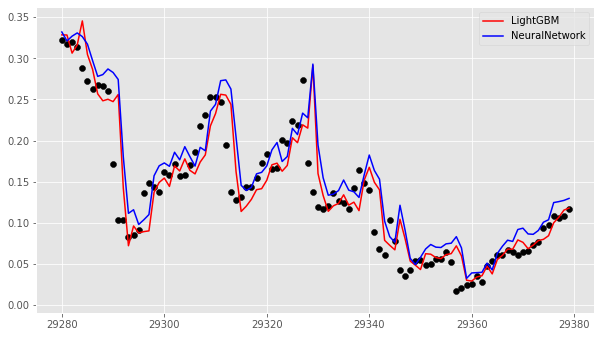

In [211]:
_time_start = 3000
_time_steps = 100
_t_steps = range(n_train_hours+_time_start, n_train_hours+_time_start+_time_steps)

plt.scatter(_t_steps,test_y[_time_start:_time_start+_time_steps],c='black');
plt.plot(_t_steps,lgbm_model.predict(feat_test[_time_start:_time_start+_time_steps]),c='r',
         label='LightGBM');
plt.plot(_t_steps,model_nn.predict(feat_test[_time_start:_time_start+_time_steps]),c='b',
         label='NeuralNetwork');
plt.legend();

In [212]:
# LGBM Predictions inverse rescaling
yhat_lgbm = lgbm_model.predict(feat_test)
inv_yhat_lgbm = np.concatenate((yhat_lgbm.reshape(-1,1),feat_test[:, -7:]),axis=1)
inv_yhat_lgbm = scaler.inverse_transform(inv_yhat_lgbm)
inv_yhat_lgbm = inv_yhat_lgbm[:,0]

# RMSE computation
rmse_lgbm = np.sqrt(mean_squared_error(inv_y, inv_yhat_lgbm))

In [213]:
print("RMSE LSTM --> {:5.3f}\nRMSE NN --> {:5.3f}\nRMSE LGBM --> {:5.3f}".format(rmse_lstm,
                                                                               rmse_nn,
                                                                               rmse_lgbm))

RMSE LSTM --> 36.575
RMSE NN --> 39.259
RMSE LGBM --> 36.649


In [214]:
print("RMSE GRU --> {:5.3f}".format(rmse_gru))

RMSE GRU --> 38.626


## CatBoost

CatBoost is a fast, scalable, high performance open-source gradient boosting on decision trees library.

Ref: https://catboost.ai/docs/

In [220]:
cat_model = CatBoostRegressor(loss_function='MAE',
                              eval_metric='MAE',
                              iterations=50,
                              random_seed=42,
                              logging_level='Silent')

In [221]:
cat_model.fit(
    feat_train, target_train,
#    cat_features=categorical_features_indices,
    eval_set=(feat_test, target_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [222]:
cat_model.best_score_

{'learn': {'MAE': 0.020188124312370402},
 'validation': {'MAE': 0.021321289939684376}}

In [223]:
cat_model.feature_importances_

array([1.68866091e+01, 1.10997564e-01, 3.14696688e-01, 1.21272020e-01,
       1.10255793e+00, 6.78733724e-01, 1.90732859e-03, 1.46613539e-02,
       1.77568438e+01, 1.89661628e-01, 2.68196735e-01, 7.98678195e-02,
       4.93705456e-01, 1.56206583e+00, 7.01782626e-03, 4.10048740e-03,
       5.72535506e+01, 3.53094643e-01, 3.33644055e-01, 2.73619526e-01,
       9.49194743e-01, 1.00793261e+00, 1.96789457e-02, 2.16389581e-01])

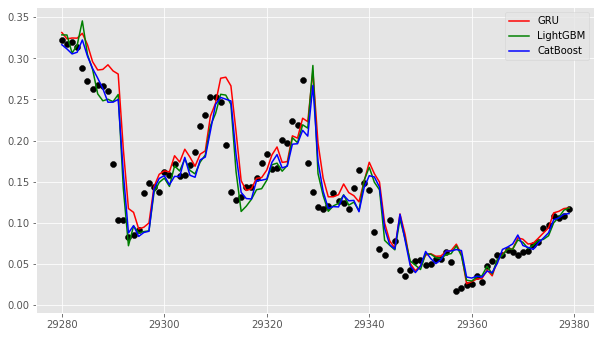

In [224]:
_time_start = 3000
_time_steps = 100
_t_steps = range(n_train_hours+_time_start, n_train_hours+_time_start+_time_steps)

plt.scatter(_t_steps,test_y[_time_start:_time_start+_time_steps],c='black');
plt.plot(_t_steps,model_gru.predict(test_X[_time_start:_time_start+_time_steps]),c='r',label='GRU');
plt.plot(_t_steps,lgbm_model.predict(feat_test[_time_start:_time_start+_time_steps]),c='g',label='LightGBM');
plt.plot(_t_steps,cat_model.predict(feat_test[_time_start:_time_start+_time_steps]),c='b',label='CatBoost');
plt.legend();

In [225]:
# CatBoost Predictions inverse rescaling
yhat_cat = cat_model.predict(feat_test)
inv_yhat_cat = np.concatenate((yhat_cat.reshape(-1,1),feat_test[:, -7:]),axis=1)
inv_yhat_cat = scaler.inverse_transform(inv_yhat_cat)
inv_yhat_cat = inv_yhat_cat[:,0]

# RMSE computation
rmse_cat = np.sqrt(mean_squared_error(inv_y, inv_yhat_cat))

In [226]:
print("RMSE LSTM --> {:5.2f}\nRMSE NN --> {:5.2f}\nRMSE LGBM --> {:5.2f}".format(rmse_lstm,
                                                                               rmse_nn,
                                                                               rmse_lgbm))

RMSE LSTM --> 36.57
RMSE NN --> 39.26
RMSE LGBM --> 36.65


In [227]:
print("RMSE GRU --> {:5.2f}".format(rmse_gru))

RMSE GRU --> 38.63


In [228]:
print("RMSE CatBoost --> {:5.2f}".format(rmse_cat))

RMSE CatBoost --> 38.78


# Comparisons

In [229]:
comparison_df = DataFrame({
        'model':['LSTM','GRU','RF','NN','LGBM','CatBoost'],
        'loss':[model.loss,model_gru.loss,rf_model.get_params()['criterion'],
                model_nn.loss,lgbm_model.params['application'],cat_model.get_all_params()['loss_function']],
        'RMSE':[rmse_lstm, rmse_gru, rmse_rf, rmse_nn, rmse_lgbm, rmse_cat]})

In [230]:
comparison_df.sort_values(by='RMSE')

,model,loss,RMSE
0,LSTM,mae,36.574963
4,LGBM,mae,36.649423
2,RF,mse,38.063366
1,GRU,mae,38.626148
5,CatBoost,MAE,38.780147
3,NN,mae,39.258991


# Classification Approach 

## Data Preparation

In [136]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 2
n_features = 8

# frame as supervised learning
# prediction after n_lag_hours
n_lag_hours = 4
reframed = series_to_supervised(scaled, n_hours, n_lag_hours)

# drop columns we don't want to predict
_var_to_drop = list(range(16,40))+list(range(41,48))
reframed.drop(reframed.columns[_var_to_drop], 
              axis=1, inplace=True)
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t+3)
2,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.109658
3,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.105634
4,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.124748
5,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.120724
6,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.132797


In [137]:
reframed.columns

Index(['var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var1(t-1)', 'var2(t-1)',
       'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)',
       'var8(t-1)', 'var1(t+3)'],
      dtype='object')

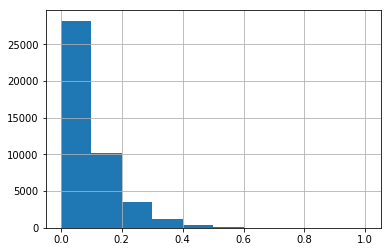

In [138]:
reframed['var1(t+3)'].hist();

In [139]:
percentile_90th = (reframed['var1(t+3)'].quantile([0.9]).values)[0]
reframed['var1(t+3)_cat'] = reframed['var1(t+3)'].apply(lambda v: 1 if v >= percentile_90th else 0)

In [155]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 36
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 17) (13140,) (30655, 1, 17) (30655,)


## LightGBM

In [156]:
feat_train = train[:,0:15]
target_train = train[:,-1]
feat_test = test[:,0:15]
target_test = test[:,-1]

In [158]:
train_lgbm = lgbm.Dataset(feat_train, label=target_train)
test_lgbm = lgbm.Dataset(feat_test, label=target_test)

In [159]:
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.4,
    'bagging_freq': 20,
    'learning_rate': 0.01,
    'verbose': 0
}

lgbm_model = lgbm.train(parameters,
                        train_lgbm,
                        valid_sets=test_lgbm,
                        num_boost_round=5000,
                        early_stopping_rounds=100)

[1]	valid_0's auc: 0.938868
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.939805
[3]	valid_0's auc: 0.947846
[4]	valid_0's auc: 0.949301
[5]	valid_0's auc: 0.949538
[6]	valid_0's auc: 0.949813
[7]	valid_0's auc: 0.949734
[8]	valid_0's auc: 0.949926
[9]	valid_0's auc: 0.949851
[10]	valid_0's auc: 0.950021
[11]	valid_0's auc: 0.952645
[12]	valid_0's auc: 0.952797
[13]	valid_0's auc: 0.952908
[14]	valid_0's auc: 0.953022
[15]	valid_0's auc: 0.953387
[16]	valid_0's auc: 0.953394
[17]	valid_0's auc: 0.954133
[18]	valid_0's auc: 0.954452
[19]	valid_0's auc: 0.954397
[20]	valid_0's auc: 0.954327
[21]	valid_0's auc: 0.954559
[22]	valid_0's auc: 0.954835
[23]	valid_0's auc: 0.955091
[24]	valid_0's auc: 0.955167
[25]	valid_0's auc: 0.955161
[26]	valid_0's auc: 0.955333
[27]	valid_0's auc: 0.955342
[28]	valid_0's auc: 0.955397
[29]	valid_0's auc: 0.955425
[30]	valid_0's auc: 0.955424
[31]	valid_0's auc: 0.955375
[32]	valid_0's auc: 0.955307
[33]	valid_0's auc

[306]	valid_0's auc: 0.95643
[307]	valid_0's auc: 0.956282
[308]	valid_0's auc: 0.956263
[309]	valid_0's auc: 0.956237
[310]	valid_0's auc: 0.956235
[311]	valid_0's auc: 0.956208
[312]	valid_0's auc: 0.956178
[313]	valid_0's auc: 0.956141
Early stopping, best iteration is:
[213]	valid_0's auc: 0.956839


In [160]:
print("AUC train --> {:3.2f}%".format(100*lgbm_model.best_score['valid_0']['auc']))

AUC train --> 95.68%


In [161]:
test_prediction = lgbm_model.predict(feat_test)

fpr_bst_test, tpr_bst_test, _ = roc_curve(target_test, test_prediction)
print("AUC test --> {:3.2f}%".format(100*auc(fpr_bst_test,tpr_bst_test)))

AUC test --> 95.68%


***